In [1]:
import sys, os, h5py
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [2]:
path_0 = "/home/dylan/Downloads"
# series = "20230504_171814"
series = "20230505_120846"
fpath  = os.path.join(path_0,series)

In [3]:
all_files = np.sort(glob(os.path.join(fpath,"Spectra_*V_"+series+".h5")))

In [4]:
print(all_files)

['/home/dylan/Downloads/20230505_120846/Spectra_0.000V_20230505_120846.h5'
 '/home/dylan/Downloads/20230505_120846/Spectra_2.500V_20230505_120846.h5'
 '/home/dylan/Downloads/20230505_120846/Spectra_3.000V_20230505_120846.h5'
 '/home/dylan/Downloads/20230505_120846/Spectra_3.500V_20230505_120846.h5'
 '/home/dylan/Downloads/20230505_120846/Spectra_4.000V_20230505_120846.h5'
 '/home/dylan/Downloads/20230505_120846/Spectra_4.500V_20230505_120846.h5'
 '/home/dylan/Downloads/20230505_120846/Spectra_5.000V_20230505_120846.h5'
 '/home/dylan/Downloads/20230505_120846/Spectra_5.500V_20230505_120846.h5'
 '/home/dylan/Downloads/20230505_120846/Spectra_6.000V_20230505_120846.h5']


In [5]:
## Plotting option
plot = False

## Plot all the spectra
if plot:
    ax = plt.figure(dpi=150).gca()
    ax.set_xlabel("Wavelength [nm]")
    ax.set_ylabel("ADC Counts")

## Get the 0 V baseline
with h5py.File(all_files[0],'r') as fyle:
    groups = np.array([k for k in fyle.keys()])
    
    avg_baseline = np.zeros(len(fyle[groups[1]][:,1]))
    n_baselines  = 0
    
    for k in groups[1:]:
        avg_baseline += fyle[k][:,1]
        n_baselines  += 1
        if plot:
            ax.plot(fyle[k][:,0],fyle[k][:,1],alpha=0.1)

    avg_baseline = avg_baseline/n_baselines
    if plot:
        ax.plot(fyle[k][:,0], avg_baseline, 'k--')
        ax.set_title(str(fyle.attrs["LEDvoltage"])+"V Baseline")

In [6]:
p_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
## Plotting option
plot = False

## Plot the rest of the data before baseline subtraction
if plot:
    ax = plt.figure(dpi=300).gca()
    ax.set_xlabel("Wavelength [nm]")
    ax.set_ylabel("ADC Counts")

## Loop over every LED voltage
f_idx = 0
for file in all_files[1:]:
    with h5py.File(file,'r') as fyle:
        groups = np.array([k for k in fyle.keys()])
        
        avg_wvfms = np.zeros(len(fyle[groups[1]][:,1]))
        n_wvfmss  = 0

        for k in groups[1:]:
            avg_wvfms += fyle[k][:,1]
            n_wvfmss  += 1
            
            if plot:
                ax.plot(fyle[k][:,0], fyle[k][:,1],
                        alpha=0.1, color=p_colors[f_idx % len(p_colors)],
                        label=str(fyle.attrs["LEDvoltage"])+"V" if k==groups[1] else None)
                
        avg_wvfms = avg_wvfms/n_wvfmss
        if plot:
            ax.plot(fyle[k][:,0], avg_wvfms-avg_baseline, ls='--', color='k')#p_colors[f_idx % len(p_colors)])    
        
    f_idx += 1

if plot:
    ax.legend(loc='best')

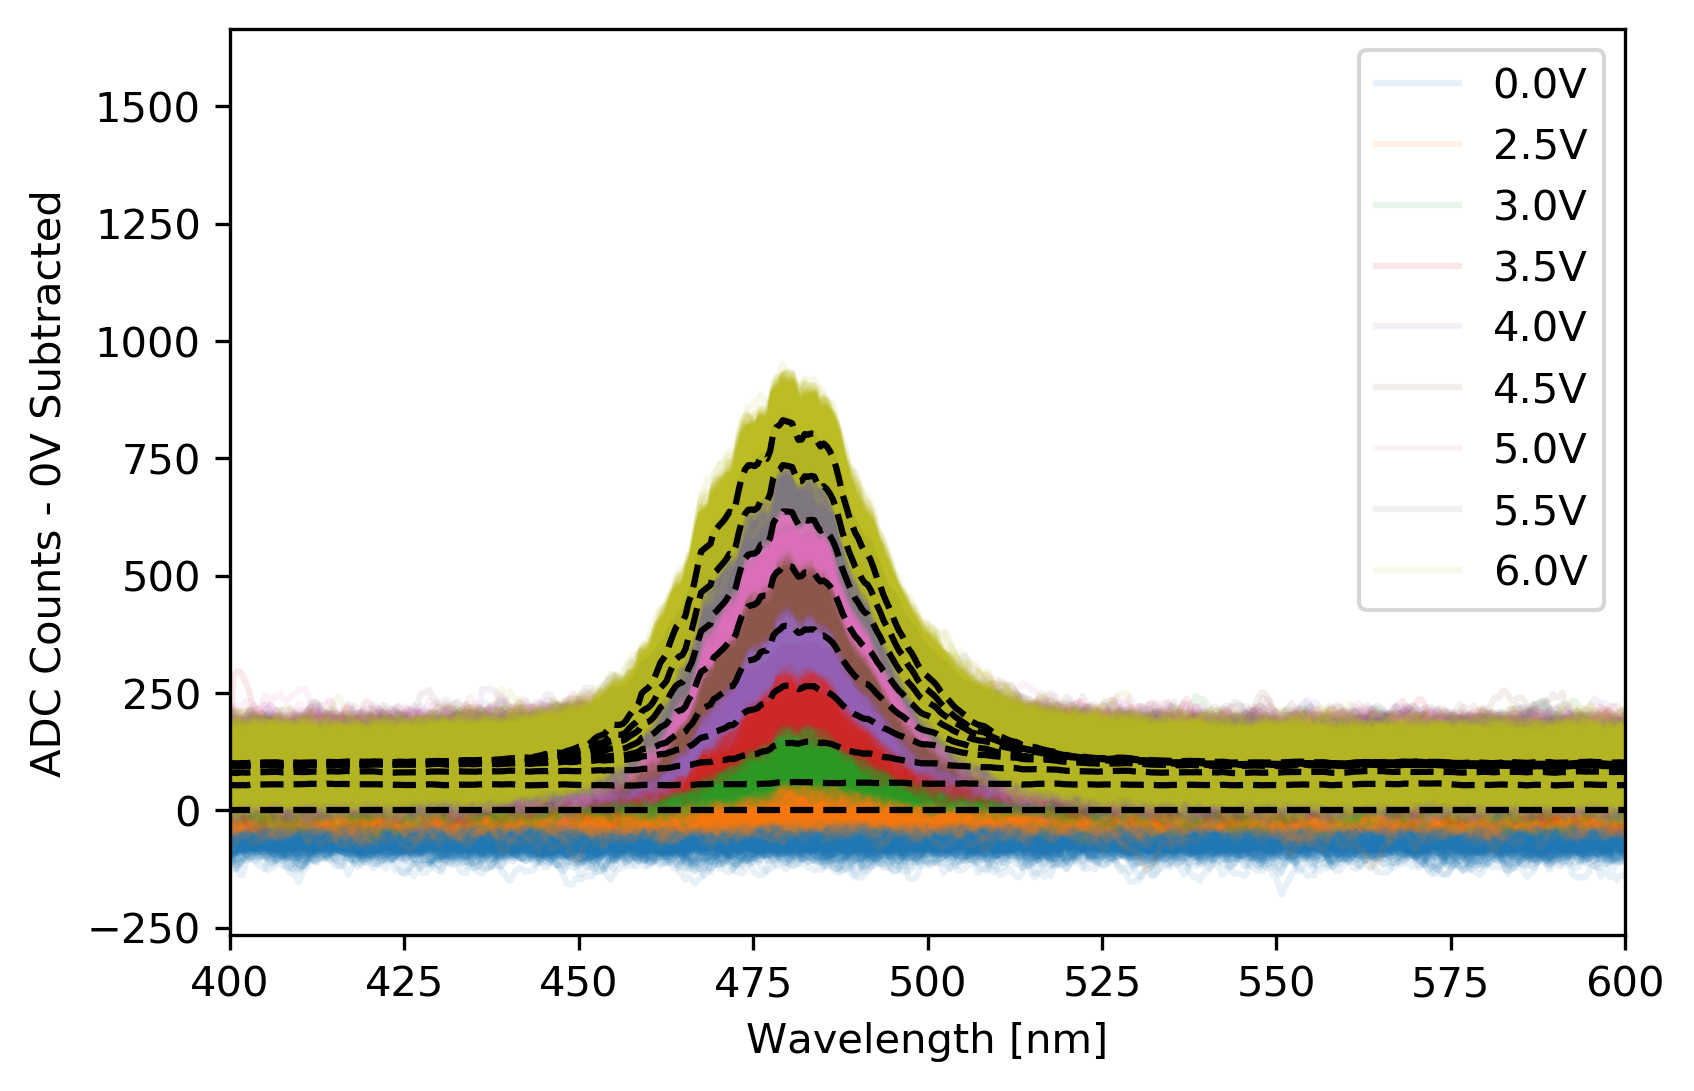

In [22]:
## Plotting option
plot = True

## Plot the rest of the data after subtraction
if plot:
    ax = plt.figure(dpi=300).gca()
    ax.set_xlabel("Wavelength [nm]")
    ax.set_ylabel("ADC Counts - 0V Subtracted")
    
## Since there's some baseline shift voltage-to-voltage, save that info
new_bl = {}

## Loop over every LED voltage
f_idx = 0
for file in all_files:#[1:]:
    with h5py.File(file,'r') as fyle:
        groups = np.array([k for k in fyle.keys()])
        
        avg_wvfms = np.zeros(len(fyle[groups[1]][:,1]))
        n_wvfmss  = 0

        for k in groups[1:]:
            avg_wvfms += fyle[k][:,1]
            n_wvfmss  += 1
            
            if plot:
                ax.plot(fyle[k][:,0], fyle[k][:,1]-avg_baseline,
                        alpha=0.1, color=p_colors[f_idx % len(p_colors)],
                        label=str(fyle.attrs["LEDvoltage"])+"V" if k==groups[1] else None)
        
        avg_wvfms = avg_wvfms/n_wvfmss
        avg_wvfms_sub = avg_wvfms-avg_baseline
        new_bl[file] = np.mean( avg_wvfms_sub[(fyle[k][:,0]>550)*(fyle[k][:,0]<600)] )
        
        if plot:
            ax.plot(fyle[k][:,0], avg_wvfms-avg_baseline, ls='--', zorder=1000, color='k')#p_colors[f_idx % len(p_colors)])
        
    f_idx += 1

if plot:
    ax.legend(loc='best')
    ax.set_xlim([400,600])

In [23]:
## Save the integrals of each acquisition into arrays
data_to_hist = {}
wl_min = 430.
wl_max = 530.

## Loop over every LED voltage
for file in all_files:#[1:]:
    with h5py.File(file,'r') as fyle:
        groups = np.array([k for k in fyle.keys()])
        
        ## Create an array to hold our integrals
        all_ingls = np.array([])

        ## Loop over all the acquisitions for this LED voltage
        for k in groups[1:]:
            this_data = fyle[k][:,1]-avg_baseline-new_bl[file]
            this_data = this_data[ (fyle[k][:,0] >= wl_min) * (fyle[k][:,0] < wl_max) ]
            data_ingl = np.sum(this_data)
            all_ingls = np.append(all_ingls, data_ingl)
        
        ## Save the array of integrals to our dict
        data_to_hist[file] = all_ingls

In [24]:
print(data_to_hist.keys())

dict_keys(['/home/dylan/Downloads/20230505_120846/Spectra_0.000V_20230505_120846.h5', '/home/dylan/Downloads/20230505_120846/Spectra_2.500V_20230505_120846.h5', '/home/dylan/Downloads/20230505_120846/Spectra_3.000V_20230505_120846.h5', '/home/dylan/Downloads/20230505_120846/Spectra_3.500V_20230505_120846.h5', '/home/dylan/Downloads/20230505_120846/Spectra_4.000V_20230505_120846.h5', '/home/dylan/Downloads/20230505_120846/Spectra_4.500V_20230505_120846.h5', '/home/dylan/Downloads/20230505_120846/Spectra_5.000V_20230505_120846.h5', '/home/dylan/Downloads/20230505_120846/Spectra_5.500V_20230505_120846.h5', '/home/dylan/Downloads/20230505_120846/Spectra_6.000V_20230505_120846.h5'])


0.000V mu= 6.988413516374276e-13 ;	sig= 5246.84135829425 ( 7.507914845051145e+17 )
2.500V mu= 218.05201683409993 ;	sig= 3362.3631319280476 ( 1542.0004734403478 )
3.000V mu= 3727.4875235782974 ;	sig= 2703.6631710108863 ( 72.53312462909159 )
3.500V mu= 9927.778430499648 ;	sig= 2447.61124685918 ( 24.654168744738957 )
4.000V mu= 17683.898729181103 ;	sig= 2354.288570565284 ( 13.313176051389346 )
4.500V mu= 25688.18516597747 ;	sig= 2420.3397781240155 ( 9.421995997325716 )
5.000V mu= 33596.35651311894 ;	sig= 2462.9642162199993 ( 7.331045600906884 )
5.500V mu= 41719.76002221294 ;	sig= 2435.277189135803 ( 5.837227222398171 )
6.000V mu= 49607.191783965354 ;	sig= 2552.345645885175 ( 5.145112138176255 )


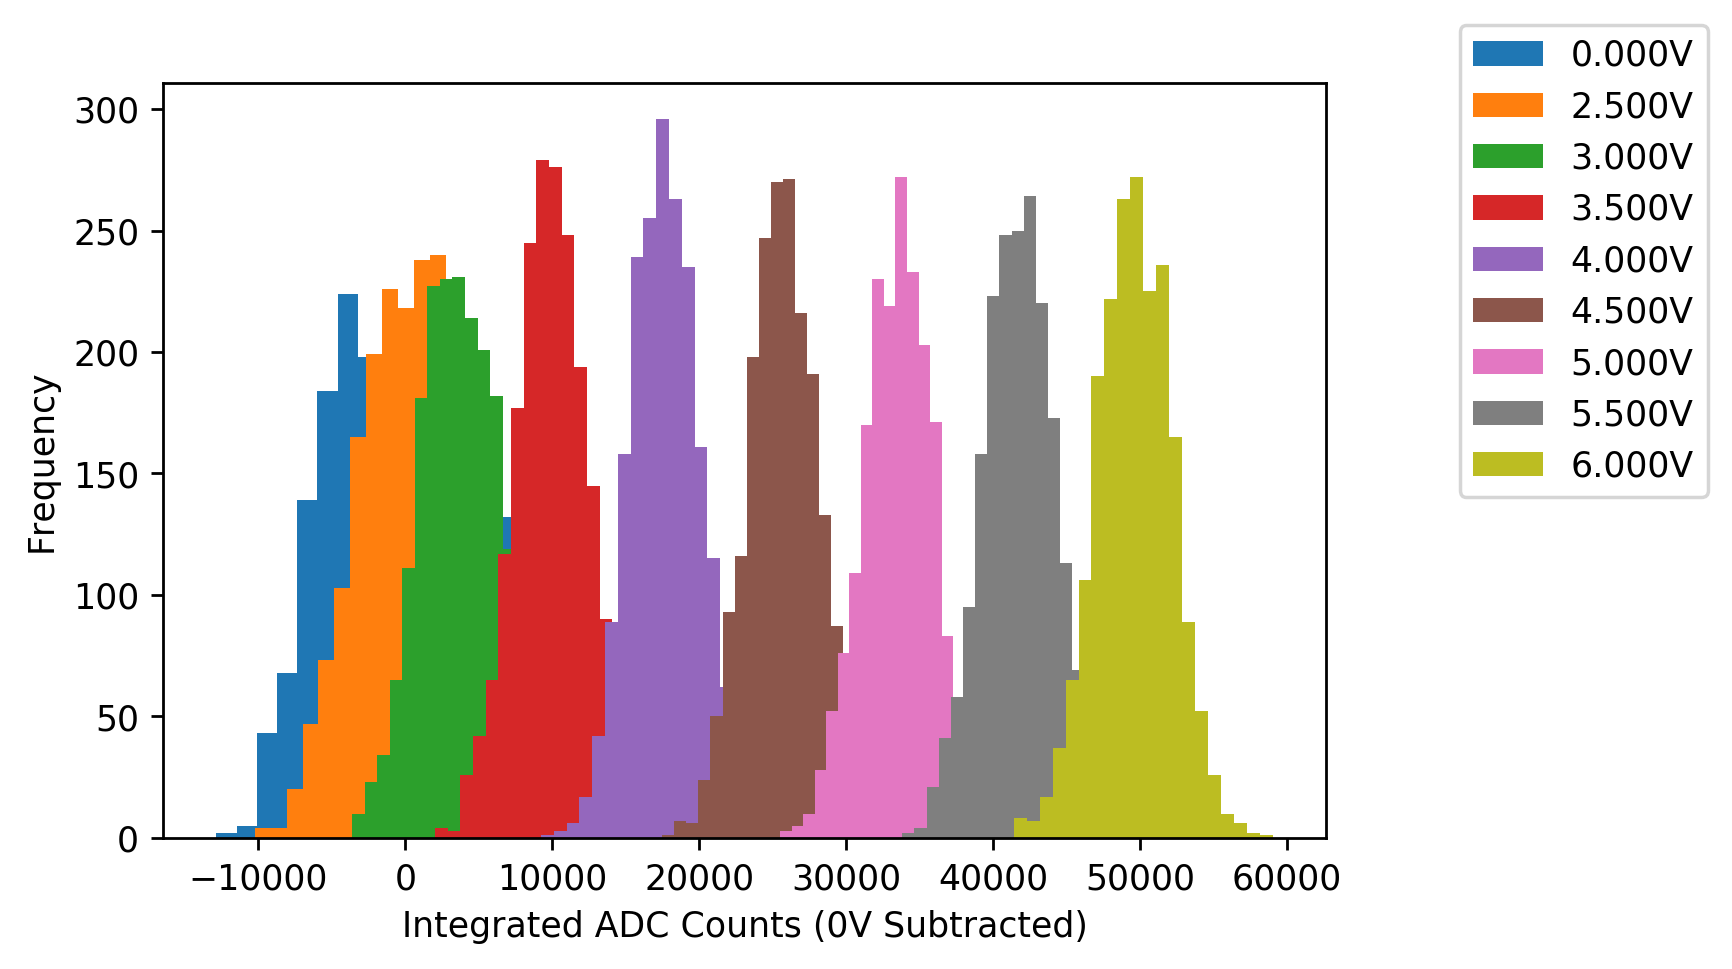

In [25]:
## Plot the histograms of integrals
ax = plt.figure(dpi=250).gca()
ax.set_xlabel("Integrated ADC Counts (0V Subtracted)")
ax.set_ylabel("Frequency")

f_idx = 0
for k in data_to_hist.keys():
    ax.hist(data_to_hist[k],bins=20,label=k.split('/')[-1].split('_')[1],color=p_colors[f_idx % len(p_colors)])
    
    mu  = np.mean(data_to_hist[k])
    sig = np.std(data_to_hist[k])
    
    print(k.split('/')[-1].split('_')[1],"mu=",mu,";\tsig=",sig,"(",sig/mu*100,")")
    
    f_idx+=1
    
# ax.legend(loc='best')
ax.legend(bbox_to_anchor=(1.1, 1.1))